Importing libaries and setting out and defining the algerbraic symbols used in the analytic part of the code.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma

INITIAL_RANGE_PARAMETER = 1 # In [fm^-2]
BETA = 0.0000001 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 10 # Determines the number of gaussians we expand our wave function to

V_LS = - 21.0 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

ORBITAL_QUANTUM_NUMBER = 0

POTENTIAL_PARAMETERS = [100., 51.0204, 26.0308, 13.281, 6.77604, 3.45716, 1.76386, 0.899927,
                        0.459147, 0.234258, 0.11952, 0.0609794]

MIXING_COEFFICIENTS = [0.00221229, 0.00130647, -0.0109408, 0.037536, -0.0872926, 0.208175, -0.496584, 1.26881, -2.68852 ,
                       2.56339, 0.186178, 0.00210103]


We now want to start defining our key functions that describe relevent parts of the system

In [13]:
def generate_betas(i, alpha_1=0.1, a=1.4):
    "gives a range param value"

    alpha = alpha_1 * a**i
    desired_param = 1/(alpha**2)
        
    return desired_param


    
def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    expression evaluated at r, array like 
    """
    return c * np.exp(-β * (r)**2)


def gaussian_expanded_potential(radius, orb_ang_moment, mixing_coefficients=MIXING_COEFFICIENTS, potential_parameters=POTENTIAL_PARAMETERS):
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    potential = 0
    for i in range(len(MIXING_COEFFICIENTS)):
        potential += single_gaussian_potential_function(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential


def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    normalisation = 1
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def complete_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    centeral_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)


    return centeral_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

We have used mathmatica to get a set of analytical expressions for our matrix elements, defined here

In [14]:
def overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return ((2 * range_param_i * range_param_j) / (range_param_i**2 + range_param_j**2))**(1.5 + orb_ang_momentum)


def potential_matrix_element(orb_ang_momentum, range_param_i, range_param_j, potential_mixing_coefficient, potential_param):
    V_0 = -11.39 * (-1)**orb_ang_momentum - 51.13 # Defines V_0 for odd and even l states
    return V_0 * potential_mixing_coefficient * (2 / (range_param_i * range_param_j * (potential_param + (
        1 / range_param_i)**2 + (1 / range_param_j)**2)))**(1.5 + orb_ang_momentum)


def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, μ=REDUCED_MASS):
    differential_term_1 = 2**(1.5 + orb_ang_momentum)
    differential_term_2 = (range_param_i * range_param_j)**(-0.5 + orb_ang_momentum)
    differential_term_3 = (range_param_i**2 + range_param_j**2)**(-2.5 - orb_ang_momentum)
    differential_term_4 = orb_ang_momentum * (range_param_i**4 - 6 * range_param_i**2 * range_param_j**2 + range_param_j**4) + (
        orb_ang_momentum**2 * (range_param_i**2 - range_param_j**2)**2) - 3 * range_param_i**2 * range_param_j**2
    differential_term_5 = gamma(0.5 + orb_ang_momentum) / gamma(1.5 + orb_ang_momentum)
    total_differential_term = differential_term_1 * differential_term_2 * differential_term_3 * differential_term_4 * differential_term_5
    # print(differential_term_1, differential_term_2, differential_term_3, differential_term_4, differential_term_5)

    centrifugal_term = (2**(2.5 + orb_ang_momentum) * orb_ang_momentum * (orb_ang_momentum + 1) * (
    range_param_i * range_param_j)**(-0.5 + orb_ang_momentum) * (range_param_i**2 + range_param_j**2)**(
        -0.5 - orb_ang_momentum)) / (1 + 2 * orb_ang_momentum)

    return (197**2 / (2 * μ)) * (centrifugal_term - total_differential_term)

Using these we can now generate our matricies to be solved, taking care to iterate over all of our potential gaussians.

In [34]:
def matrix_generation(orb_ang_momentum, potential_mixing_coefficients=MIXING_COEFFICIENTS,
                      potential_parameters=POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            potential_energy_term = 0
            for k in range(len(MIXING_COEFFICIENTS)):
                potential_energy_term += potential_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter,
                                                                  potential_mixing_coefficients[k],
                                                                  potential_parameters[k])
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # ((2 * 10**(np.abs(i - j))) / (1 + 10**(2 * np.abs(i - j))))**(1.5 + orb_ang_momentum)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1

    return h_matrix, n_matrix


def next_range_parameter(i, initial_range_parameter=INITIAL_RANGE_PARAMETER, geometric_progression_number=2):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    new_range_parameter = initial_range_parameter * geometric_progression_number**(i)
    return new_range_parameter

# def range_parameter(i, first=0.49, last=4, n=SUM_LIMIT):
#     """
#     Finds the next range parameter given the previous and initial range parameters.
#     Currently using a simple geometric series to determine range parameters.
#     Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

#     Parameters
#     ----------
#     i : int detailing the iteration number

#     Returns
#     -------
#     new_range_parameter: float

#     """
#     range_parameter = first * np.exp(np.log(last/first)*((i-1)/(n-1)))
#     return range_parameter

We now generate and then save the matrices to csv files to save having to use the computation time to rerun them every time we restart the code.

In [35]:
h_matrix, n_matrix = matrix_generation(ORBITAL_QUANTUM_NUMBER)
# print(h_matrix)
# print(n_matrix)
#np.savetxt('s_state_h_matrix.csv', h_matrix, delimiter=',')
#np.savetxt('s_state_n_matrix.csv', n_matrix, delimiter=',')


With our matrices found we now calculate the eigenvalues and the groundstate eigenvector, corresponding to the lowest (hence groundstate) energy.

In [36]:
eigenvalues, eigenvectors = scipy.linalg.eigh(h_matrix, n_matrix)
overlap_eigenvalues, overlap_eigenvectors = scipy.linalg.eigh(n_matrix)
overlap_matrix_condition_number = np.max(overlap_eigenvalues) / np.min(overlap_eigenvalues)
print(f"The overlap matrix condition number is", overlap_matrix_condition_number)

ground_state_eigenvector = np.asmatrix(eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(eigenvectors[:, 1])
print("The eigenvalues are", eigenvalues)
print("The groundstate eigenvector is", ground_state_eigenvector)

The overlap matrix condition number is 73.89815782885175
The eigenvalues are [-3.27140123e+01 -3.39896565e-01  2.43858045e-04  1.52636548e-03
  6.93912232e-03  3.10508434e-02  1.48422620e-01  8.47731395e-01
  4.86930438e+00  6.21424541e+01]
The groundstate eigenvector is [[-2.77964262e-02  9.24945046e-01  1.41491087e-01 -3.73606597e-02
   1.68881975e-02 -7.98445165e-03  3.77708453e-03 -1.75766245e-03
   7.61544968e-04 -2.38307192e-04]]


a

In [37]:
normalisation_check = ground_state_eigenvector * n_matrix * np.transpose(ground_state_eigenvector)
print("normalisation = ", normalisation_check[0, 0])

normalisation =  0.9999999999999993


With our normalised groundstate eigenvector we have the coeffffficients of our expansion terms. With these we get our terms in the expasion of u(r) as a set of gaussians (solved numerically rather than as an sympy expression)

In [49]:
def radial_wavefunction(x_values, wavefunction_eigenvector, orbital_quantum_number=ORBITAL_QUANTUM_NUMBER, sum_limit=SUM_LIMIT):
    """
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    """
    wavefunction_vals = np.zeros(shape=(1, len(x_values)))[0, :]

    for i in range(len(x_values)):
        for j in range(sum_limit):
            range_parameter = next_range_parameter(j)
            wavefunction_vals[i] += (wavefunction_eigenvector[0, j] * gaussian_wavefunction(x_values[i], 
                range_parameter, orbital_quantum_number))
        wavefunction_vals[i] = wavefunction_vals[i]**2
    return wavefunction_vals

"""
def reduced_radial_wavefunction(x_values, wavefunction_eigenvector, orbital_quantum_number=ORBITAL_QUANTUM_NUMBER, sum_limit=SUM_LIMIT):
    
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    
    range_parameter_array = np.zeros(shape=(1, sum_limit))
    for i in range(sum_limit):
        range_parameter_array[0, i] = next_range_parameter(i)

    wavefunction_vals = np.zeros(shape=(1, xvals))
    for i in range(xvals):
        for j in range(sum_limit):
            wavefunction_vals[0, i] += wavefunction_eigenvector[0, j] * gaussian_wavefunction(x_values[i], 
                range_parameter_array[0, j], orbital_quantum_number) * x_values[i]
    return wavefunction_vals[0, :]**2
"""

'\ndef reduced_radial_wavefunction(x_values, wavefunction_eigenvector, orbital_quantum_number=ORBITAL_QUANTUM_NUMBER, sum_limit=SUM_LIMIT):\n    \n    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.\n    \n    range_parameter_array = np.zeros(shape=(1, sum_limit))\n    for i in range(sum_limit):\n        range_parameter_array[0, i] = next_range_parameter(i)\n\n    wavefunction_vals = np.zeros(shape=(1, xvals))\n    for i in range(xvals):\n        for j in range(sum_limit):\n            wavefunction_vals[0, i] += wavefunction_eigenvector[0, j] * gaussian_wavefunction(x_values[i], \n                range_parameter_array[0, j], orbital_quantum_number) * x_values[i]\n    return wavefunction_vals[0, :]**2\n'

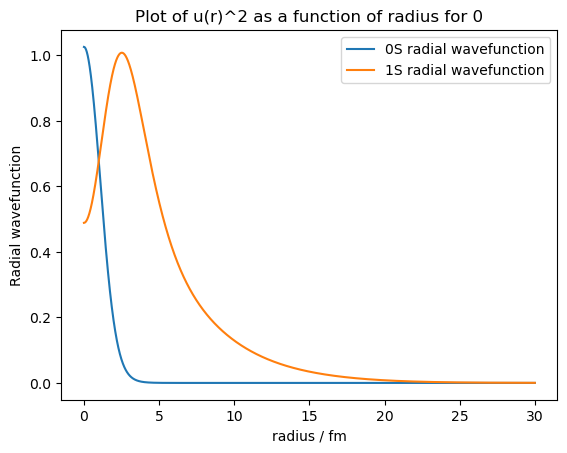

In [50]:
def induvidual_gaussian_plots(x_vals, ax, orbital_quantum_number=ORBITAL_QUANTUM_NUMBER):
    for i in range(SUM_LIMIT):
        range_parameter = next_range_parameter(i)
        ax.plot(x_vals, gaussian_wavefunction(x_vals, range_parameter, orbital_quantum_number))
    return 0

fig = plt.figure()
ax = fig.add_subplot()

x_values = np.linspace(0., 30, 3000)
#evaluated_ur_values = reduced_radial_wavefunction(x_values, ground_state_eigenvector, 0)[0]
#print(reduced_radial_wavefunction(x_values))

ax.set_title(f'Plot of u(r)^2 as a function of radius for {ORBITAL_QUANTUM_NUMBER}')
ax.set_xlabel('radius / fm')
ax.set_ylabel('Radial wavefunction')
ax.plot(x_values, radial_wavefunction(x_values, ground_state_eigenvector, ORBITAL_QUANTUM_NUMBER), label="0S radial wavefunction")
#induvidual_gaussian_plots(x_values, ax)
ax.plot(x_values, radial_wavefunction(x_values, s1_eigenvector, ORBITAL_QUANTUM_NUMBER), label="1S radial wavefunction")
ax.legend()

plt.savefig('s_state_plot.png', dpi=300)
plt.show()

i


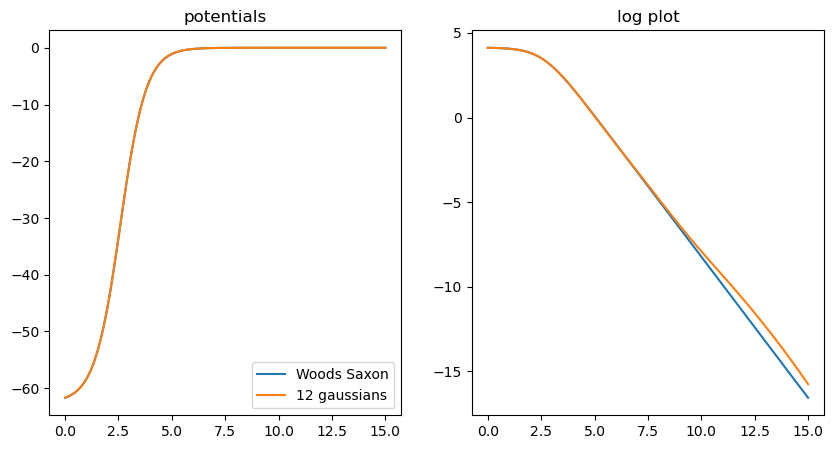

In [40]:
fig = plt.figure(figsize = (10,5))
X_vals = np.linspace(0.0000000000001, 15, 100)

def single_gaussian_potential_function_plot(radius, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    sympy expression
    """
    return c * np.exp(-β * (radius)**2)

def gaussian_potential_plot(radius, l, mixing_coefficients=MIXING_COEFFICIENTS, betas=POTENTIAL_PARAMETERS):
    """
    Defines the spherically symmetric gaussian potential as a function of radius we use as a 'first guess'
    to make our integrals analytic. Given as V = V_0 * e**(-beta * radius**2)

    Parameters
    ----------
    radius : float
    parameters : 1d array containg the fixed parameters for our potential. In the order [V_0, beta] (see slides/supplimentary notes) 

    Returns
    -------
    float with the value of the potential at a radius r

    """
    V_0 = -11.39 * (-1)**l - 51.13 # Defines V_0 for odd and even l states
    return V_0 * (single_gaussian_potential_function_plot(radius, mixing_coefficients[0], betas[0])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[1], betas[1]) 
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[2], betas[2])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[3], betas[3])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[4], betas[4])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[5], betas[5])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[6], betas[6])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[7], betas[7])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[8], betas[8])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[9], betas[9])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[10], betas[10])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[11], betas[11])
        
    )

spec = fig.add_gridspec(ncols=2, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])

ax_1.plot(X_vals, complete_potential(X_vals, 0.5, 0), label = 'Woods Saxon')
ax_1.plot(X_vals, gaussian_potential_plot(X_vals, 0), label = '12 gaussians')
ax_1.legend()
ax_1.set_title('potentials')
print('i')

ax_2.plot(X_vals, np.log(-complete_potential(X_vals, 0.5, 0)), label = '12 gaussians')
ax_2.plot(X_vals, np.log(-gaussian_potential_plot(X_vals, 0)), label = '12 gaussians')
ax_2.set_title('log plot')

plt.show()